# Import libraries and modules

In [42]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import warnings
from contextlib import contextmanager
from copy import copy
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

from ck_utils import ck_constraints, extract_and_save_k_values

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 20
n_samples_train = 16257
n_samples_test = 16257

poly_order = 2
threshold = 0
dt = 1

EPS = 1e-10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [43]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

# Load data

In [44]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

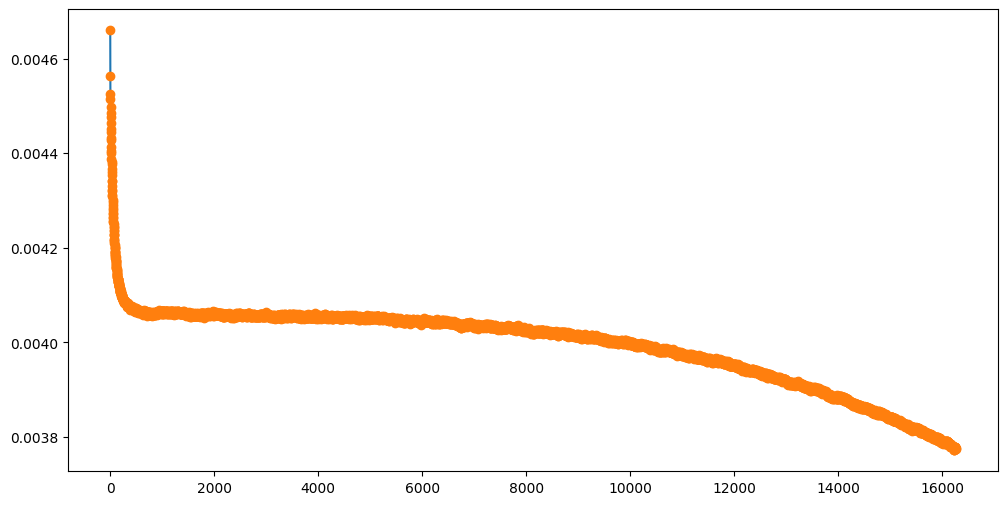

In [45]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Prepare the model (add constraints)

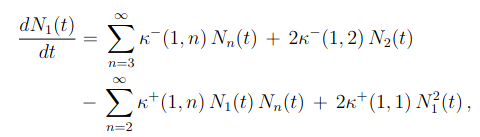

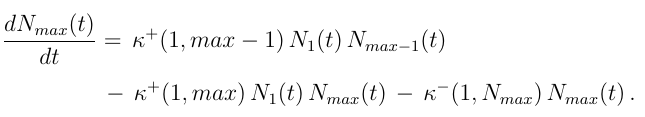

In [46]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
feature_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", feature_names)

Features (231): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16', 'x1 x17', 'x1 x18', 'x1 x19', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x2 x15', 'x2 x16', 'x2 x17', 'x2 x18', 'x2 x19', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x3 x15', 'x3 x16', 'x3 x17', 'x3 x18', 'x3 x19', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x4 x15', 'x4 x16', 'x4 x17', 'x4 x18', 'x4

## Set inequalities

In [47]:
# Repeat with inequality constraints, need CVXPY installed
try:
    import cvxpy  # noqa: F401

    run_cvxpy = True

    # eps = np.sqrt(np.finfo(float).eps)
    eps_value = 1e-6
    large_value = 1e6

    print('eps:', eps_value)
    print('large_value:', large_value)

except ImportError:
    run_cvxpy = False
    print("No CVXPY package is installed")

constraint_lhs, constraint_rhs = ck_constraints(N_clusters_train, feature_names)

eps: 1e-06
large_value: 1000000.0


# Build and fit the model

In [48]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
differentiation_method = smoothed_fd

optimizer = ps.ConstrainedSR3(
    verbose=True,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,  # Ensure this is True for inequality constraints
    thresholder="l2",
    tol=1e-12,
    threshold=1e-12,
    max_iter=500000,
)

feature_library = ps.PolynomialLibrary(degree=poly_order)

with ignore_specific_warnings():
    # Fit the model
    model = ps.SINDy( 
        # discrete_time=True,
        differentiation_method=differentiation_method,
        optimizer=optimizer,
        feature_library=feature_library,
    )
    model.fit(N_clusters_train, t=dt)

# Print the model
model.print(precision=6)

model.save('.', precision=6)

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)


/u1/ame805/pysindy_fork/venv-pysindy/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


         0 ... 1.1055e-08 ... 2.6764e+09 ... 2.6762e-15 ... 2.6764e+09
(x0)' = 0.000257 x1 + 0.004583 x2 + 0.020446 x3 + 0.064329 x4 + 0.235415 x5 + 1.254407 x6 + 3.193985 x7 + 4.112971 x8 + 4.564921 x9 + 4.803753 x10 + 4.943597 x11 + 5.027877 x12 + 5.083285 x13 + 5.120197 x14 + 5.147524 x15 + 5.168132 x16 + 5.184009 x17 + 5.196448 x18 + 5.203228 x19 + 0.011259 x0^2 + -33.632322 x0 x1 + -6.609672 x0 x2 + -5.616556 x0 x3 + -5.385421 x0 x4 + -5.317454 x0 x5 + -5.294953 x0 x6 + -5.286095 x0 x7 + -5.282313 x0 x8 + -5.280444 x0 x9 + -5.279427 x0 x10 + -5.278866 x0 x11 + -5.278515 x0 x12 + -5.278337 x0 x13 + -5.278207 x0 x14 + -5.278094 x0 x15 + -5.278023 x0 x16 + -5.277974 x0 x17 + -5.277872 x0 x18
(x1)' = -0.000129 x1 + 0.004583 x2 + 0.005630 x0^2 + -3.617073 x0 x1
(x2)' = -0.004583 x2 + 0.020446 x3 + 7.832899 x0 x1 + -6.609672 x0 x2
(x3)' = -0.020446 x3 + 0.064329 x4 + 6.609672 x0 x2 + -5.616556 x0 x3
(x4)' = -0.064329 x4 + 0.235415 x5 + 5.616556 x0 x3 + -5.385421 x0 x4
(x5)' = -0.235415 

In [49]:
extract_and_save_k_values(feature_names, optimizer)

# Simulate and plot results

In [54]:
# integrator_kws['method'] = 'Euler'   # 'RK2'   #'RK4' 
# integrator_kws['h_factor'] = 1000

# integrator = "solve_ivp"   # 'fixed_step'
# integrator_kws = {"method": "LSODA", 
#                     "rtol": EPS, "atol": EPS, 
#                     "max_step": 0.1,
#                     "h_factor": 1}

integrator = 'odeint'
integrator_kws = {'rtol': EPS, 'atol': EPS}

if integrator == 'odeint':
    n_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                              integrator=integrator, integrator_kws=integrator_kws)
else:
    n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                                integrator=integrator, integrator_kws=integrator_kws)

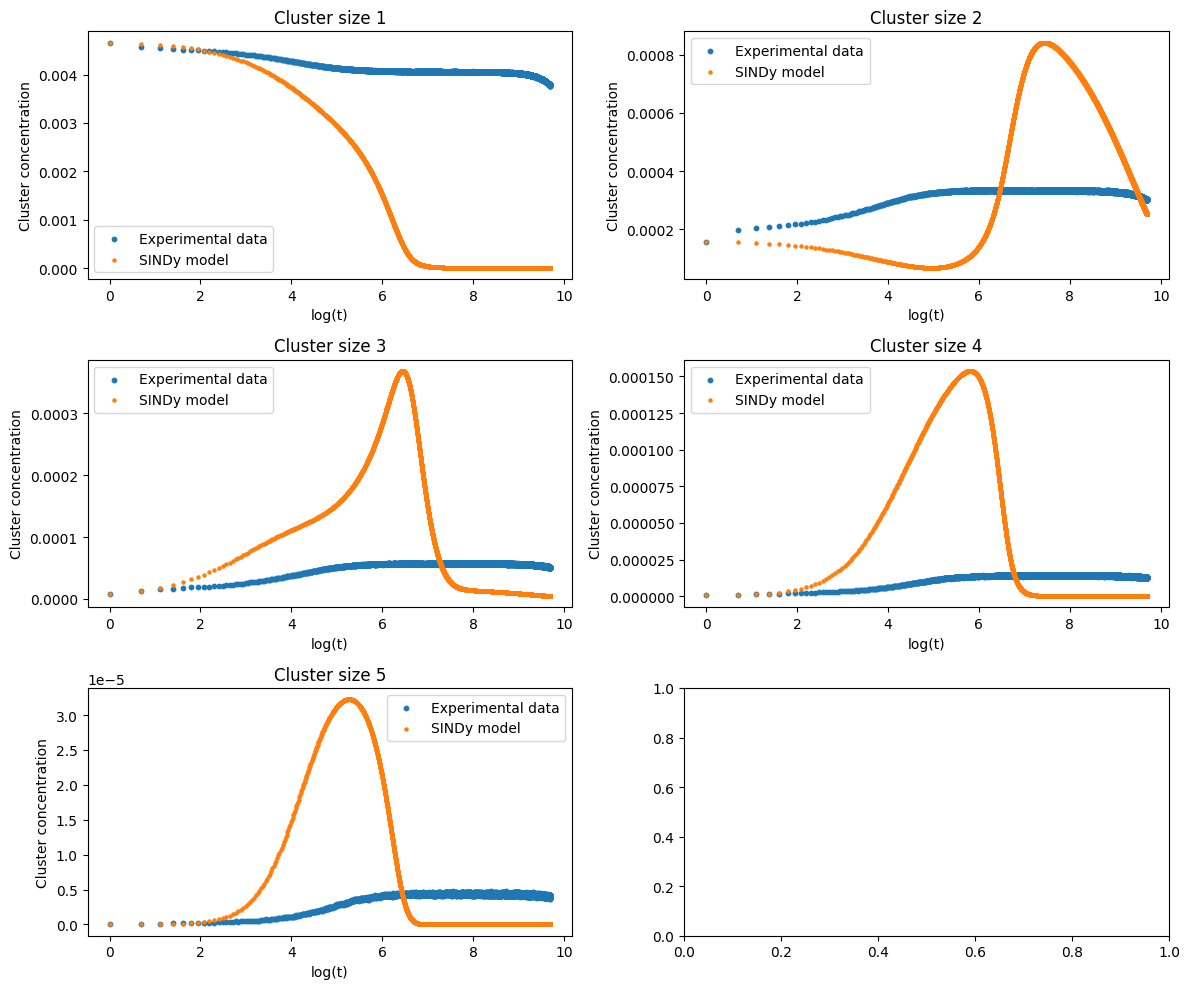

In [55]:
# List of IDs to plot
# ids_to_plot = [1, 2, 3, 10, 50, 100]
ids_to_plot = [1, 2, 3, 4, 5]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log1p(t_values)
t_sim_log = np.log1p(t_values[:n_samples_test])

for ci, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[ci].scatter(t_values_log, N_clusters[:, n_to_plot-1], s=10, label=f'Experimental data')
    axs[ci].scatter(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model', s=5)
    axs[ci].set_title(f'Cluster size {n_to_plot}')
    axs[ci].legend()
    
    axs[ci].set_xlabel('log(t)')
    axs[ci].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.savefig('sindy_model.png', dpi=300)
plt.show()
